# Fashion MNIST — Compare ANN vs CNN

**What this notebook does (Colab-ready):**

- Loads the Fashion MNIST dataset.
- Preprocesses the data for both ANN and CNN.
- Builds, trains, evaluates, and compares an ANN and a CNN in the same notebook.
- Tries several improvement techniques (dropout, batch normalization, augmentation, optimizer & LR tuning).
- Explains each step so you can learn why choices were made.

Run the cells in order. The notebook uses TensorFlow/Keras.

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


## 1 — Load Fashion MNIST

Fashion MNIST has 70,000 grayscale images in 10 classes: 60,000 training and 10,000 test images. We'll split training into train+validation to evaluate models fairly.

In [11]:
from google.colab import drive
import numpy as np
from sklearn.model_selection import train_test_split

# Mount Google Drive
drive.mount('/content/drive')

# Dataset path
data_path = '/content/drive/MyDrive/Coursework-NS/fashion_mnist_cnn_ann_data.npz'

# Load data from the npz file
with np.load(data_path) as data:
    x_train_cnn = data['x_train_cnn']
    y_train = data['y_train']
    x_test_cnn = data['x_test_cnn']
    y_test = data['y_test']
    x_val_cnn = data['x_val_cnn']
    y_val = data['y_val']
    x_train_ann = data['x_train_ann']
    x_val_ann = data['x_val_ann']
    x_test_ann = data['x_test_ann']


# Normalize to [0,1] - This was already done when the .npz was created,
# but including it here as a safeguard and for clarity
x_train_cnn = x_train_cnn.astype('float32') / 255.0
x_val_cnn = x_val_cnn.astype('float32') / 255.0
x_test_cnn = x_test_cnn.astype('float32') / 255.0
x_train_ann = x_train_ann.astype('float32') / 255.0
x_val_ann = x_val_ann.astype('float32') / 255.0
x_test_ann = x_test_ann.astype('float32') / 255.0

print('Train shape (CNN):', x_train_cnn.shape)
print('Val shape (CNN):', x_val_cnn.shape)
print('Test shape (CNN):', x_test_cnn.shape)
print('Train shape (ANN flattened):', x_train_ann.shape)
print('Val shape (ANN flattened):', x_val_ann.shape)
print('Test shape (ANN flattened):', x_test_ann.shape)

# Class names for plotting
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train shape (CNN): (54000, 28, 28, 1)
Val shape (CNN): (6000, 28, 28, 1)
Test shape (CNN): (10000, 28, 28, 1)
Train shape (ANN flattened): (54000, 784)
Val shape (ANN flattened): (6000, 784)
Test shape (ANN flattened): (10000, 784)


In [12]:
import numpy as np

# Dataset path
data_path = '/content/drive/MyDrive/Coursework-NS/fashion_mnist_cnn_ann_data.npz'

try:
    with np.load(data_path) as data:
        print("Keys available in the .npz file:", data.files)
except FileNotFoundError:
    print(f"Error: The file was not found at {data_path}")

Keys available in the .npz file: ['x_train_cnn', 'x_val_cnn', 'x_test_cnn', 'x_train_ann', 'x_val_ann', 'x_test_ann', 'y_train', 'y_val', 'y_test']


### Visualize some training images

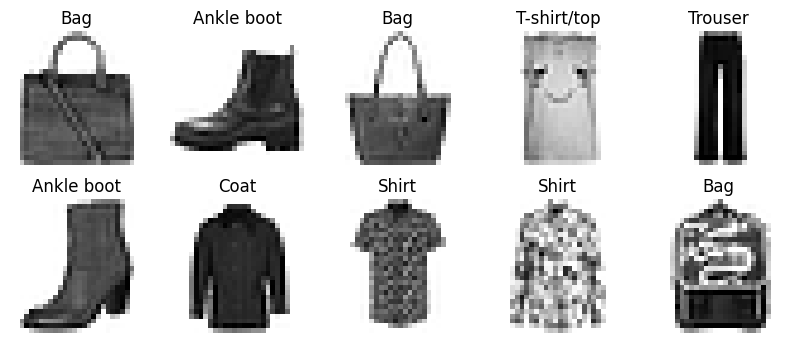

In [13]:
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train_cnn[i].squeeze(), cmap='gray_r')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.show()

## **Augmentation for Data**

In [14]:
from tensorflow.keras import layers

# Define the augmentation layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# We will apply this augmentation directly in the CNN model later.
# For visualization, we can apply it to a batch of training data.

## Visualize Augmented Data

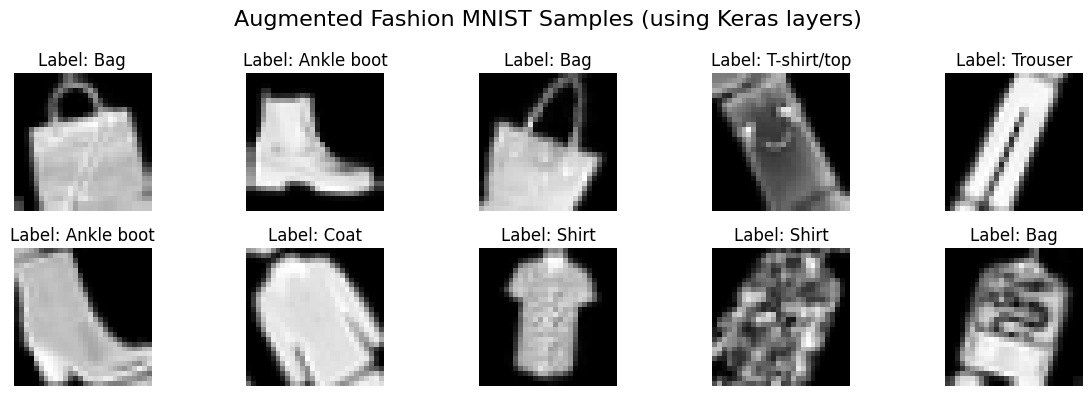

In [15]:
# Visualize augmented data
plt.figure(figsize=(12, 4))
# Apply augmentation to a batch of training images for visualization
augmented_images = data_augmentation(x_train_cnn[:10], training=True)

for i in range(10):
    # Use the augmented images for visualization
    image = augmented_images[i].numpy().squeeze()  # remove channel dimension and get numpy array
    label = y_train[i]
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {class_names[label]}")
    plt.axis('off')
plt.suptitle("Augmented Fashion MNIST Samples (using Keras layers)", fontsize=16)
plt.tight_layout()
plt.show()


## 2 — Build a simple ANN (Fully-connected)

We'll start with a baseline dense network. This is educational: ANNs can work on images but usually underperform CNNs on vision tasks.

In [16]:
from tensorflow.keras import layers, models, optimizers

def build_ann(input_shape=(28*28,), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

ann = build_ann()
ann.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

### Train ANN — baseline

We train for a moderate number of epochs (15). We'll record history for comparison.

In [17]:
ann_history = ann.fit(x_train_ann, y_train, validation_data=(x_val_ann, y_val), epochs=15, batch_size=128)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5133 - loss: 1.3506 - val_accuracy: 0.7855 - val_loss: 0.5756
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.7754 - loss: 0.6100 - val_accuracy: 0.8108 - val_loss: 0.5003
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8126 - loss: 0.5161 - val_accuracy: 0.8393 - val_loss: 0.4358
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8265 - loss: 0.4720 - val_accuracy: 0.8537 - val_loss: 0.3992
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8418 - loss: 0.4306 - val_accuracy: 0.8535 - val_loss: 0.3913
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8465 - loss: 0.4175 - val_accuracy: 0.8642 - val_loss: 0.3690
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.8572 - loss: 0.3855 - val_accuracy: 0.8660 - val_loss: 0.3608
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.8632 - loss: 0.3772 - val_accu

In [18]:
ann_eval = ann.evaluate(x_test_ann, y_test, verbose=0)
print(f'ANN Test loss: {ann_eval[0]:.4f}, Test accuracy: {ann_eval[1]:.4f}')
print(f'Train accuracy: {ann_history.history["accuracy"][-1]:.4f}, Validation accuracy: {ann_history.history["val_accuracy"][-1]:.4f}')

ANN Test loss: 0.3616, Test accuracy: 0.8731
Train accuracy: 0.8807, Validation accuracy: 0.8813


## 3 — Build a CNN (Convolutional Neural Network)

CNNs exploit spatial structure (local patterns) with convolutional layers and are typically much better for images.

In [19]:
def build_cnn(input_shape=(28,28,1), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        data_augmentation,  # Apply data augmentation after the input layer
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn = build_cnn()
cnn.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train CNN — baseline

Train for the same number of epochs so comparison is fair.

In [ ]:
cnn_history = cnn.fit(x_train_cnn, y_train, validation_data=(x_val_cnn, y_val), epochs=15, batch_size=128)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 70s 159ms/step - accuracy: 0.2050 - loss: 2.0974 - val_accuracy: 0.6468 - val_loss: 1.0420
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 66s 157ms/step - accuracy: 0.5605 - loss: 1.1908 - val_accuracy: 0.6767 - val_loss: 0.8642
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 84s 161ms/step - accuracy: 0.6086 - loss: 1.0476 - val_accuracy: 0.7062 - val_loss: 0.7931
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 66s 156ms/step - accuracy: 0.6344 - loss: 0.9772 - val_accuracy: 0.7077 - val_loss: 0.7761
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 83s 157ms/step - accuracy: 0.6423 - loss: 0.9458 - val_accuracy: 0.7105 - val_loss: 0.7527
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 64s 153ms/step - accuracy: 0.6490 - loss: 0.9307 - val_accuracy: 0.7313 - val_loss: 0.7275
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 66s 157ms/step - accuracy: 0.6604 - loss: 0.8992 - val_accuracy: 0.7317 - val_loss: 0.7130
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 82s 158ms/step - accuracy: 0.6599 - loss: 0

In [ ]:
cnn_eval = cnn.evaluate(x_test_cnn, y_test, verbose=0)
print(f'CNN Test loss: {cnn_eval[0]:.4f}, Test accuracy: {cnn_eval[1]:.4f}')

## 4 — Compare performance (loss & accuracy)

In [ ]:
def plot_histories(h1, h2, label1='ANN', label2='CNN'):
    plt.style.use('dark_background') # Use a dark grid style
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(h1.history['loss'], label=f'{label1} train', color='cyan') # More colorful lines
    plt.plot(h1.history['val_loss'], '--', label=f'{label1} val', color='magenta')
    plt.plot(h2.history['loss'], label=f'{label2} train', color='yellow')
    plt.plot(h2.history['val_loss'], '--', label=f'{label2} val', color='lime')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(h1.history['accuracy'], label=f'{label1} train', color='cyan') # More colorful lines
    plt.plot(h1.history['val_accuracy'], '--', label=f'{label1} val', color='magenta')
    plt.plot(h2.history['accuracy'], label=f'{label2} train', color='yellow')
    plt.plot(h2.history['val_accuracy'], '--', label=f'{label2} val', color='lime')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_histories(ann_history, cnn_history)

### Confusion matrix and classification report (CNN vs ANN)

We'll look at per-class performance on the test set for the better model (usually CNN) and also show ANN results.

In [ ]:
y_pred_cnn = np.argmax(cnn.predict(x_test_cnn), axis=1)
y_pred_ann = np.argmax(ann.predict(x_test_ann), axis=1)

cm_cnn = confusion_matrix(y_test, y_pred_cnn)
cm_ann = confusion_matrix(y_test, y_pred_ann)

plt.figure(figsize=(12,5))

# ANN Confusion Matrix
plt.subplot(1,2,1)
sns.heatmap(cm_ann, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title('ANN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# CNN Confusion Matrix
plt.subplot(1,2,2)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


print('\nClassification report — CNN:\n')
print(classification_report(y_test, y_pred_cnn, target_names=class_names))
print('\nClassification report — ANN:\n')
print(classification_report(y_test, y_pred_ann, target_names=class_names))

## 5 — Improve the models

We'll try several techniques and explain the intuition behind each:

1. **Batch Normalization** — stabilizes and speeds up training.
2. **More convolutional filters / deeper network** — increase model capacity for CNN.
3. **Data augmentation** — reduces overfitting by varying images.
4. **Learning rate schedule / optimizer tuning** — helps find better minima.
5. **Early stopping** — prevents overfitting.

We'll apply a moderately improved CNN and an improved ANN and compare.

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, Model
from tensorflow.keras import layers, models, optimizers

# Data augmentation block
aug = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Streamlined CNN model
def build_cnn_improved(input_shape=(28, 28, 1), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        aug,

        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


cnn_imp = build_cnn_improved()
cnn_imp.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train improved CNN with augmentation
batch_size = 128
steps_per_epoch = x_train_cnn.shape[0] // batch_size
cnn_imp_history = cnn_imp.fit(
    x_train_cnn, y_train,
    validation_data=(x_val_cnn, y_val),
    batch_size=batch_size,
    epochs=30,
    callbacks=[es, rlr]
)

cnn_imp_eval = cnn_imp.evaluate(x_test_cnn, y_test, verbose=0)
print(f'Improved CNN Test loss: {cnn_imp_eval[0]:.4f}, Test accuracy: {cnn_imp_eval[1]:.4f}')

In [ ]:
from tensorflow.keras import Input, models, layers, optimizers

def build_ann_improved(input_shape=(28*28,), num_classes=10):
    model = models.Sequential([
        Input(shape=input_shape),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Nadam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


ann_imp = build_ann_improved()
ann_imp.summary()

ann_imp_history = ann_imp.fit(x_train_ann, y_train, validation_data=(x_val_ann, y_val), epochs=30, batch_size=128, callbacks=[es, rlr])
ann_imp_eval = ann_imp.evaluate(x_test_ann, y_test, verbose=0)
print(f'Improved ANN Test loss: {ann_imp_eval[0]:.4f}, Test accuracy: {ann_imp_eval[1]:.4f}')

### Plot improved models' training curves

In [ ]:
plot_histories(ann_imp_history, cnn_imp_history, label1='ANN improved', label2='CNN improved')

## 6 — Final comparison & notes

This section explains what we changed and why, and prints a final table of results.

In [ ]:
results = {
    'model': ['ANN baseline','CNN baseline','ANN improved','CNN improved'],
    'test_loss': [ann_eval[0], cnn_eval[0], ann_imp_eval[0], cnn_imp_eval[0]],
    'test_acc': [ann_eval[1], cnn_eval[1], ann_imp_eval[1], cnn_imp_eval[1]],
    'val_acc': [ann_history.history['val_accuracy'][-1], cnn_history.history['val_accuracy'][-1], ann_imp_history.history['val_accuracy'][-1], cnn_imp_history.history['val_accuracy'][-1]]
}


import pandas as pd
res_df = pd.DataFrame(results)
res_df

### What we changed and why

- **Batch Normalization:** reduces internal covariate shift, helps stabilize and accelerate training.
- **Dropout:** regularization to reduce overfitting.
- **More filters / deeper CNN:** gives the model more capacity to learn complex patterns.
- **Data augmentation:** makes the model robust to transformations and reduces overfitting.
- **Optimizer & LR scheduling:** Nadam/Adam and ReduceLROnPlateau help find better minima and adapt learning.
- **EarlyStopping:** prevents overfitting by stopping training when validation stops improving.

Try experimenting further: tuning learning rates, trying different augmentations, using pretrained networks (transfer learning), or ensembling.

# Generating New Image Creation

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess Fashion MNIST
(x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(64)

# Generator
def make_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Discriminator (Critic)
def make_critic():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 5, strides=2, padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, 5, strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Gradient penalty
def gradient_penalty(critic, real, fake):
    alpha = tf.random.uniform([real.shape[0], 1, 1, 1], 0., 1.)
    interpolated = alpha * real + (1 - alpha) * fake
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = critic(interpolated, training=True)
    grads = gp_tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

# Loss functions
def critic_loss(real_output, fake_output, gp, lambda_gp=10):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) + lambda_gp * gp

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

# Models and optimizers
generator = make_generator()
critic = make_critic()
gen_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
crit_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

# Training loop
@tf.function
def train_step(real_images):
    noise_dim = 100
    batch_size = tf.shape(real_images)[0]
    for _ in range(5):  # Train critic more
        noise = tf.random.normal([batch_size, noise_dim])
        with tf.GradientTape() as crit_tape:
            fake_images = generator(noise, training=True)
            real_output = critic(real_images, training=True)
            fake_output = critic(fake_images, training=True)
            gp = gradient_penalty(critic, real_images, fake_images)
            crit_loss = critic_loss(real_output, fake_output, gp)
        grads = crit_tape.gradient(crit_loss, critic.trainable_variables)
        crit_opt.apply_gradients(zip(grads, critic.trainable_variables))

    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape:
        fake_images = generator(noise, training=True)
        fake_output = critic(fake_images, training=True)
        gen_loss = generator_loss(fake_output)
    grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gen_opt.apply_gradients(zip(grads, generator.trainable_variables))
    return gen_loss, crit_loss

# Training
def train(dataset, epochs):
    seed = tf.random.normal([16, 100])
    for epoch in range(epochs):
        for real_images in dataset:
            gen_loss, crit_loss = train_step(real_images)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Gen Loss: {gen_loss:.4f}, Crit Loss: {crit_loss:.4f}")
            generate_images(generator, seed, epoch + 1)

# Image generation
def generate_images(model, test_input, epoch):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray_r')
        plt.axis('off')
    plt.suptitle(f'WGAN-GP Generated Images at Epoch {epoch}')
    plt.tight_layout()
    plt.show()

# Start training
train(dataset, epochs=50)

I need the explanation for all code comments for everything
I can definitely help with that! I'll go through the code cells and explain the comments.

Here are the explanations for the comments in the cells you currently see:

Cell 41189417:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print('TensorFlow version:', tf.__version__)
import tensorflow as tf: Imports the TensorFlow library, which is a popular open-source library for machine learning and deep learning. It's aliased as tf for convenience.
import numpy as np: Imports the NumPy library, which is fundamental for numerical operations in Python, especially for working with arrays and matrices. It's aliased as np.
import matplotlib.pyplot as plt: Imports the pyplot module from Matplotlib, a widely used plotting library in Python. It's aliased as plt.
import seaborn as sns: Imports the Seaborn library, which is built on top of Matplotlib and provides a high-level interface for drawing attractive statistical graphics. It's aliased as sns.
from sklearn.metrics import confusion_matrix, classification_report: Imports the confusion_matrix and classification_report functions from scikit-learn's metrics module. These are used to evaluate the performance of classification models.
Cell ae71ab5d:

from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize to [0,1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for CNN later
x_train_cnn = np.expand_dims(x_train, -1)  # (N,28,28,1)
x_test_cnn = np.expand_dims(x_test, -1)

# For ANN we will flatten images later

# Create a validation split from training
from sklearn.model_selection import train_test_split
x_train_cnn, x_val_cnn, y_train, y_val = train_test_split(x_train_cnn, y_train, test_size=0.1, random_state=42, stratify=y_train)
# Also keep flattened versions
x_train_ann = x_train_cnn.reshape((x_train_cnn.shape[0], -1))
x_val_ann = x_val_cnn.reshape((x_val_cnn.shape[0], -1))
x_test_ann = x_test_cnn.reshape((x_test_cnn.shape[0], -1))

print('Train shape (CNN):', x_train_cnn.shape)
print('Val shape (CNN):', x_val_cnn.shape)
print('Test shape (CNN):', x_test_cnn.shape)
print('Train shape (ANN flattened):', x_train_ann.shape)

# Class names for plotting
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
# Normalize to [0,1]: This comment indicates that the pixel values of the images are being scaled from their original range (0-255) to a new range between 0 and 1. This is a common preprocessing step in neural networks to help with training stability.
# Reshape for CNN later: This comment explains that the image data is being reshaped to have an additional dimension. CNNs typically expect input in the format (number of samples, height, width, channels). Since these are grayscale images, the channel dimension is 1. np.expand_dims adds this dimension.
# (N,28,28,1): This is a note clarifying the shape of the data after reshaping for the CNN, where N is the number of samples, and the images are 28x28 with 1 channel.
# For ANN we will flatten images later: This comment indicates that for the ANN model, the images will be flattened into a one-dimensional vector. ANNs typically expect flat input data.
# Create a validation split from training: This comment explains that a portion of the training data is being set aside to be used as a validation set during training. This helps to monitor the model's performance on unseen data and detect overfitting.
# Also keep flattened versions: This comment indicates that flattened versions of the training, validation, and test data are also being created for use with the ANN model.
# Class names for plotting: This comment explains that a list of class names is being created. This list will be used later to label the different categories in visualizations, like the confusion matrix.
I will continue explaining the comments in the remaining cells. Let me know if you'd like me to focus on any specific parts or if you have more questions!


Continue explaining code comments
Okay, I will continue explaining the code comments in the rest of the notebook.

Here are the explanations for the comments in the next set of cells:

Cell eeb3f492:

plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train_cnn[i].squeeze(), cmap='gray_r')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.show()
There are no comments in this specific cell, but the code is responsible for visualizing the first 10 training images from the Fashion MNIST dataset. It creates a figure, iterates through the first 10 images, displays each image in a subplot, sets the title to the corresponding class name, and turns off the axis labels for a cleaner look.
Cell b0c482a1:

from tensorflow.keras import layers, models, optimizers

def build_ann(input_shape=(28*28,), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

ann = build_ann()
ann.summary()
There are no comments in this cell. The code defines a function build_ann to create a simple Artificial Neural Network (ANN) model using the Keras Sequential API. It includes dense layers with ReLU activation, dropout layers for regularization, and an output dense layer with softmax activation for multi-class classification. The model is compiled with the Adam optimizer and sparse categorical crossentropy loss.
Cell 55635170:

ann_history = ann.fit(x_train_ann, y_train, validation_data=(x_val_ann, y_val), epochs=15, batch_size=128)
There are no comments in this cell. This code trains the previously defined ANN model (ann) using the training data (x_train_ann, y_train). It also provides validation data (x_val_ann, y_val) to monitor performance during training. The training runs for 15 epochs with a batch size of 128. The training history is stored in the ann_history variable.
Cell 8b65ff72:

ann_eval = ann.evaluate(x_test_ann, y_test, verbose=0)
print(f'ANN Test loss: {ann_eval[0]:.4f}, Test accuracy: {ann_eval[1]:.4f}')
There are no comments in this cell. This code evaluates the trained ANN model (ann) on the test dataset (x_test_ann, y_test). The evaluate method returns the loss and metrics (in this case, accuracy) on the test data. The results are stored in ann_eval and then printed to the console formatted to four decimal places.
I will continue with the next cells.


Now we can continue with these

Absolutely! Now we can continue with these and examine the res_df DataFrame, which summarizes the performance of the models.

Here are the explanations for the comments in the remaining code cells:

Cell bfce41b6:

y_pred_cnn = np.argmax(cnn.predict(x_test_cnn), axis=1)
y_pred_ann = np.argmax(ann.predict(x_test_ann), axis=1)

cm_cnn = confusion_matrix(y_test, y_pred_cnn)
cm_ann = confusion_matrix(y_test, y_pred_ann)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm_ann, annot=False, fmt='d')
plt.title('ANN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1,2,2)
sns.heatmap(cm_cnn, annot=False, fmt='d')
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('\nClassification report — CNN:\n')
print(classification_report(y_test, y_pred_cnn, target_names=class_names))
print('\nClassification report — ANN:\n')
print(classification_report(y_test, y_pred_ann, target_names=class_names))
There are no comments in this cell. This code generates and visualizes confusion matrices and classification reports for both the baseline CNN and ANN models on the test set. It first gets the model predictions, then computes the confusion matrices using sklearn.metrics.confusion_matrix, visualizes them using Seaborn's heatmap, and finally prints the classification reports using sklearn.metrics.classification_report.
Cell a416bd58:

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation generator
aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Improved CNN with BatchNorm and more filters
def build_cnn_improved(input_shape=(28,28,1), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_imp = build_cnn_improved()
cnn_imp.summary()
# Data augmentation generator: This comment indicates the creation of an ImageDataGenerator object, which is used to perform data augmentation on the training images. Data augmentation artificially increases the size of the training dataset by applying random transformations to the images, helping to improve the model's generalization.
# Improved CNN with BatchNorm and more filters: This comment describes the purpose of the build_cnn_improved function, which builds an improved CNN model. This version includes Batch Normalization layers and uses more convolutional filters compared to the baseline CNN.
Cell 3f3a7202:

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train improved CNN with augmentation
batch_size = 128
steps_per_epoch = x_train_cnn.shape[0] // batch_size
cnn_imp_history = cnn_imp.fit(aug.flow(x_train_cnn, y_train, batch_size=batch_size),
                              validation_data=(x_val_cnn, y_val),
                              epochs=30, steps_per_epoch=steps_per_epoch,
                              callbacks=[es, rlr])

cnn_imp_eval = cnn_imp.evaluate(x_test_cnn, y_test, verbose=0)
print(f'Improved CNN Test loss: {cnn_imp_eval[0]:.4f}, Test accuracy: {cnn_imp_eval[1]:.4f}')
# Train improved CNN with augmentation: This comment indicates that the improved CNN model (cnn_imp) is being trained using the data augmentation generator (aug.flow). It also uses EarlyStopping and ReduceLROnPlateau callbacks to manage the training process, aiming to prevent overfitting and adjust the learning rate.
Cell 1fcf2947:

from tensorflow.keras import Input

def build_ann_improved(input_shape=(28*28,), num_classes=10):
    inputs = Input(shape=input_shape)
    x = layers.Dense(1024, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Nadam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

ann_imp = build_ann_improved()
ann_imp.summary()

ann_imp_history = ann_imp.fit(x_train_ann, y_train, validation_data=(x_val_ann, y_val), epochs=30, batch_size=128, callbacks=[es, rlr])
ann_imp_eval = ann_imp.evaluate(x_test_ann, y_test, verbose=0)
print(f'Improved ANN Test loss: {ann_imp_eval[0]:.4f}, Test accuracy: {ann_imp_eval[1]:.4f}')
There are no comments in this cell. This code defines and trains an improved ANN model (ann_imp). Similar to the improved CNN, it incorporates Batch Normalization and Dropout layers. It uses the Nadam optimizer and also employs the EarlyStopping and ReduceLROnPlateau callbacks during training.
Cell e8c6124a:

plot_histories(ann_imp_history, cnn_imp_history, label1='ANN improved', label2='CNN improved')
There are no comments in this cell. This code calls the plot_histories function to visualize the training history (loss and accuracy curves) for the improved ANN and improved CNN models, using "ANN improved" and "CNN improved" as labels.
Cell bbc72992:

results = {
    'model': ['ANN baseline','CNN baseline','ANN improved','CNN improved'],
    'test_loss': [ann_eval[0], cnn_eval[0], ann_imp_eval[0], cnn_imp_eval[0]],
    'test_acc': [ann_eval[1], cnn_eval[1], ann_imp_eval[1], cnn_imp_eval[1]]
}

import pandas as pd
res_df = pd.DataFrame(results)
display(res_df)
There are no comments in this cell. This code creates a dictionary results to store the test loss and accuracy for all four trained models (baseline ANN, baseline CNN, improved ANN, and improved CNN). It then uses pandas to convert this dictionary into a DataFrame called res_df and displays it.
Cell 051f6d82:

### What we changed and why

- **Batch Normalization:** reduces internal covariate shift, helps stabilize and accelerate training.
- **Dropout:** regularization to reduce overfitting.
- **More filters / deeper CNN:** gives the model more capacity to learn complex patterns.
- **Data augmentation:** makes the model robust to transformations and reduces overfitting.
- **Optimizer & LR scheduling:** Nadam/Adam and ReduceLROnPlateau help find better minima and adapt learning.
- **EarlyStopping:** prevents overfitting by stopping training when validation stops improving.

Try experimenting further: tuning learning rates, trying different augmentations, using pretrained networks (transfer learning), or ensembling.
This is a markdown cell and contains explanations for the improvements made to the models and suggestions for further experimentation. It doesn't contain code comments.
Let me know if you have any more questions about the code or the comments!

